Debemos preparar datos, probar varios modelos, preseleccionar los mejores, ajustar sus hiperparámetros usando GridSearchCV y automatizar todo lo posible

# Dataset

https://www.kaggle.com/datos_estudiantessets/kundanbedmutha/exam-score-prediction-dataset?resource=download

# Imports
Importamos todos lso elementos que usaremos a lo largo del notebook. También, definimos la semilla utilizada para que todas las ejecuciones tengan el mismo resultado

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import io

from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Definimos la semilla
np.random.seed(42)

# Carga del dataset

In [15]:
datos_estudiantes = pd.read_csv("Datasets/Exam_Score_Prediction.csv", sep=',', index_col="student_id")
datos_estudiantes.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
student_id,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


# Selección y extracción de atributos

Vamos a comenzar reduciendo el número de atributos de nuestra dataset, lo cual es muy importante para evitar la maldición de la dimensionalidad (curse of dimensionality). En caso contrario, los efetos serían:

- Cuando aumenta la dimensionalidad, el volumen del espacio aumenta exponencialmente haciendo que los datos disponibles se vuelvan dispersos. 
- Esta dispersión impide que los algoritmos de aprendizaje puedan construir buenos modelos.

La estrategias que utilizaremos para luchar contra la maldición de la dimensionalidad sonla selección y extracción de atributos. 

En primer lugar, construiremos nuevos atributos a partir de los originales.Posteriormente, seleccionaremos un buen conjunto de atributos. 

In [16]:
#Creamos un atributo para saber si han aprobado
datos_estudiantes['passed']=datos_estudiantes['exam_score']>=50.00

#Creamos un atributo para saber si la calificación obtenida es failed, passed, good, merit o excellent
def calculo_calificacion_estudiante(estudiante):
    if (estudiante.loc['exam_score']<50.00):
        return 'failed'
    elif (estudiante.loc['exam_score']<60.00):
        return 'passed'
    elif (estudiante.loc['exam_score']<70.00):
        return 'good'
    elif (estudiante.loc['exam_score']<90.00):
        return 'merit'
    else:
        return 'Excellent'
    
datos_estudiantes['mark']=datos_estudiantes.apply(lambda datos_estudiantes:calculo_calificacion_estudiante(datos_estudiantes), axis=1)

datos_estudiantes

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9,True,passed
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8,True,passed
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3,True,Excellent
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7,False,failed
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7,False,failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,18,other,bba,6.50,71.3,yes,5.0,good,self-study,low,easy,86.5,True,merit
19998,18,male,b.com,3.71,41.6,no,5.9,average,coaching,medium,moderate,60.9,True,good
19999,19,other,diploma,7.88,68.2,yes,4.6,poor,group study,low,easy,64.5,True,good


A continuación, para poder utilizar los algoritmos, preprocesamos el dataframe datos_estudiantes para tener exclusivamente datos numéricos

In [17]:
def preprocesamiento_calificaciones(datos_estudiantes):
    if datos_estudiantes['mark']=='failed':
        m=0
    elif datos_estudiantes['mark']=='passed':
        m=1
    elif datos_estudiantes['mark']=='good':
        m=2
    elif datos_estudiantes['mark']=='merit':
        m=3
    else:
        m=4
    datos_estudiantes['mark']=m
    return datos_estudiantes
    

datos_estudiantes = datos_estudiantes.apply(preprocesamiento_calificaciones, axis=1)
datos_estudiantes

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9,True,1
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8,True,1
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3,True,4
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7,False,0
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,18,other,bba,6.50,71.3,yes,5.0,good,self-study,low,easy,86.5,True,3
19998,18,male,b.com,3.71,41.6,no,5.9,average,coaching,medium,moderate,60.9,True,2
19999,19,other,diploma,7.88,68.2,yes,4.6,poor,group study,low,easy,64.5,True,2


Para evitar realizar este trabajo manualmente, utilizaremos la función LabelEncoder() de scikitLearn, que nos ayudará a transformar todos los valores de un atributo a números

Para cada atributo, seguimos el siguiente proceso:
1. Generamos el encoder.
2. Ajustamos el encoder al atributo.
3. Transformamos los valores a numérico.
4. Imprimimos en consola un mensaje para saber qué atributo se está transformando
5. 

In [18]:
gender_encoder = LabelEncoder()
gender_encoder.fit(datos_estudiantes['gender'])
datos_estudiantes['gender'] = gender_encoder.transform(datos_estudiantes['gender'])
print("Codificamos el género")
print(list(gender_encoder.classes_))
print(gender_encoder.transform(gender_encoder.classes_))

course_encoder = LabelEncoder()
course_encoder.fit(datos_estudiantes['course'])
datos_estudiantes['course'] = course_encoder.transform(datos_estudiantes['course'])
print("\nCourse codification")
print(list(course_encoder.classes_))
print(course_encoder.transform(course_encoder.classes_))

internet_access_encoder = LabelEncoder()
internet_access_encoder.fit(datos_estudiantes['internet_access'])
datos_estudiantes['internet_access'] = internet_access_encoder.transform(datos_estudiantes['internet_access'])
print("\nCourse codification")
print(list(internet_access_encoder.classes_))
print(internet_access_encoder.transform(internet_access_encoder.classes_))

sleep_quality_encoder = LabelEncoder()
sleep_quality_encoder.fit(datos_estudiantes['sleep_quality'])
datos_estudiantes['sleep_quality'] = sleep_quality_encoder.transform(datos_estudiantes['sleep_quality'])
print("\nSleep Quality codification")
print(list(sleep_quality_encoder.classes_))
print(sleep_quality_encoder.transform(sleep_quality_encoder.classes_))

study_method_encoder = LabelEncoder()
study_method_encoder.fit(datos_estudiantes['study_method'])
datos_estudiantes['study_method'] = study_method_encoder.transform(datos_estudiantes['study_method'])
print("\nStudy Method codification")
print(list(study_method_encoder.classes_))
print(study_method_encoder.transform(study_method_encoder.classes_))

facility_rating_encoder = LabelEncoder()
facility_rating_encoder.fit(datos_estudiantes['facility_rating'])
datos_estudiantes['facility_rating'] = facility_rating_encoder.transform(datos_estudiantes['facility_rating'])
print("\nFacility Rating codification")
print(list(facility_rating_encoder.classes_))
print(facility_rating_encoder.transform(facility_rating_encoder.classes_))

exam_difficulty_encoder = LabelEncoder()
exam_difficulty_encoder.fit(datos_estudiantes['exam_difficulty'])
datos_estudiantes['exam_difficulty'] = exam_difficulty_encoder.transform(datos_estudiantes['exam_difficulty'])
print("\nExam Difficulty codification")
print(list(exam_difficulty_encoder.classes_))
print(exam_difficulty_encoder.transform(exam_difficulty_encoder.classes_))

passed_encoder = LabelEncoder()
passed_encoder.fit(datos_estudiantes['passed'])
datos_estudiantes['passed'] = passed_encoder.transform(datos_estudiantes['passed'])
print("\nExam Difficulty codification")
print(list(passed_encoder.classes_))
print(passed_encoder.transform(passed_encoder.classes_))

Codificamos el género
['female', 'male', 'other']
[0 1 2]

Course codification
['b.com', 'b.sc', 'b.tech', 'ba', 'bba', 'bca', 'diploma']
[0 1 2 3 4 5 6]

Course codification
['no', 'yes']
[0 1]

Sleep Quality codification
['average', 'good', 'poor']
[0 1 2]

Study Method codification
['coaching', 'group study', 'mixed', 'online videos', 'self-study']
[0 1 2 3 4]

Facility Rating codification
['high', 'low', 'medium']
[0 1 2]

Exam Difficulty codification
['easy', 'hard', 'moderate']
[0 1 2]

Exam Difficulty codification
[False, True]
[0 1]


In [19]:
datos_estudiantes.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,1,6,2.78,92.9,1,7.4,2,0,1,1,58.9,1,1
2,23,2,5,3.37,64.8,1,4.6,0,3,2,2,54.8,1,1
3,22,1,1,7.88,76.8,1,8.5,2,0,0,2,90.3,1,4
4,20,2,6,0.67,48.4,1,5.8,0,3,1,2,29.7,0,0
5,20,0,6,0.89,71.6,1,9.8,2,0,1,2,43.7,0,0


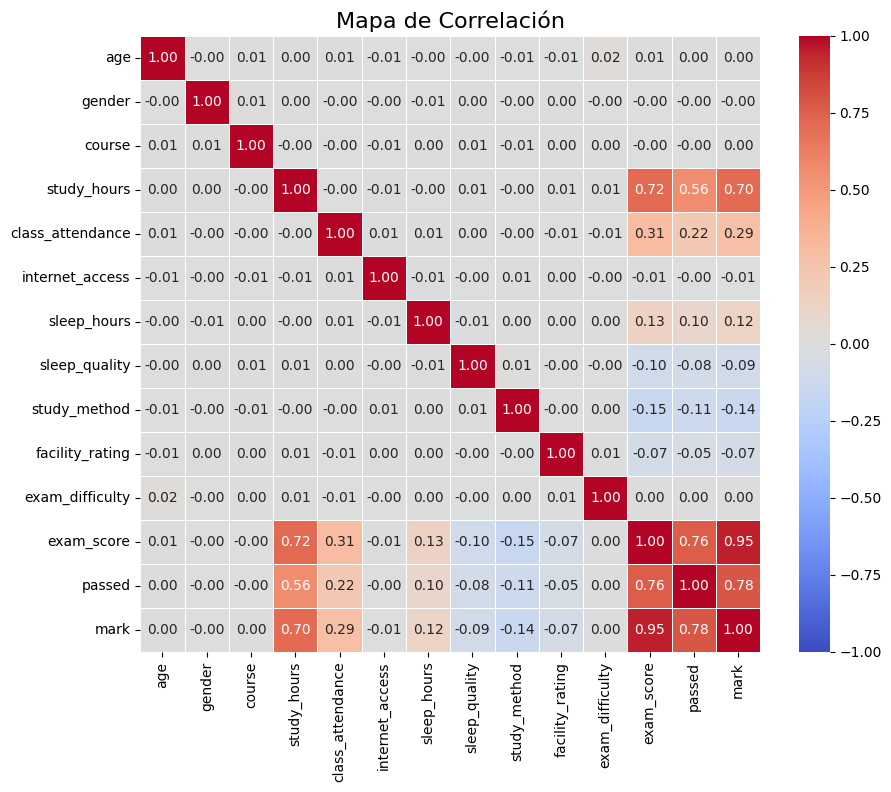

In [20]:
matriz_correlacion = datos_estudiantes.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Mapa de Correlación', fontsize=16)
plt.show()

# Clasificación

Las tareas de clasificación pertenecen al aprendizaje supervisado y consisten en predecir la clase a la que pertenece un individuo.

El conjunto de datos seleccionado contiene información sobre datos académicos, hábitos y la rutina de 20.000 estudiantes de entre 17 y 24 años. Esta información nos permitirá entender cómo diferentes aspectos en la vida de un estudiante afectan a su rendimiento académico.

En concreto, los 13 atributos son los siguientes:

* Student_id: identificador único del estudiante (1 - 20.000)
* Age: edad (17 - 24 años)
* Gender: género (male, female, other)
* Course: curso de estudio.
  * Diploma: Formación Profesional
  * Bachelor of Computer Aplications (BCA): grado de aplicaciones de computación, aplicado a la informática y desarrollo de software
  * Bachelor of Science (B.Sc): grado de ciencias (sin especificar la especialidad)
  * Bachelor of Technology (B.Tech): ingeniería
  * Bachelor of Business Administration (BBA): grado en administración de empresas
  * Bachelor of Arts: grado en artes o humanidades.
  * Bachelor of Commerce (B.Com): grado en comercio, contabilidad o finanzas
* Study_hours: horas de estudio (0.00 - 7.91)
* Class_attendance: porcentaje de asistencia a clases (40.6 - 99.4)
* Internet_access: acceso a internet (true/false)
* Sleep_hours: Horas de sueño diarias (4.1 - 9.9)
* Sleep_quality: Calidad del sueño (poor, average, good)
* Study_method: método de estudio (self-study, online videos, coaching, group study, mixed)
* Facility_rating: valoración del lugar de estudio (low, medium, high)
* Exam_difficulty: dificultad del examen (easy, moderate, high)
* Exam_score: puntuación en el examen (0.00 - 100.00)
* Nueva columna: calificación --> failed, passed, good, merit, excellent

Nuestro objetivo es que, gracias a estos atributos que comprenden un amplio espectro de influencias observadas comúnmente en ambientes académicos, podamos entender con facilidad qué aspectos son más importantes en el rendimiento académico.

En concreto, se van a responder las siguientes preguntas:

* ¿Qué perfiles existen?
* ¿Qué modelo ofrece una mayor precisión para la predicción de exam_difficulty, facility_rating, study_method, sleep_quality, internet_access, course o gender?
* Se observa algo interesante entre sleep_quality y sleep_hours
* Qué atributos tienen más importancia y cómo el rendimiento al no usar exam_difficulty para evitar depender de la dificultad del examen
* Qué importancia tiene asistencia frente a horas de estudio para clasificar "calificación"
* ¿Qué comportamiento aparece al introducir variables derivadas como 'ratio de estudio - sueño' o 'índice de hábito'?
* Qué reglas extrae un árbol
* ¿Se mantiene el rendimiento al excluir algún curso del entrenamiento y test?
* ¿Cómo de robusto es el modelo a valores extremos o inconsistentes (outliers)?
* ¿Qué sucede si faltan datos en sleep_quality o internet_Access y se imputa?
* ¿Se cumple una igualdad entre subgrupos para la clase clasificación?
* Qué impacto tiene eliminar el género sobre el rendimiento global
* ¿Qué patrones caracterizan a los falsos positivos y falsos negativos?
* ¿Se concentran los falsos positivo/negativo en estudiantes con calificaciones excelentes?
* Cómo queda la matriz de confusión con las calificaciones?
* ¿Hay alguna métrica más informativa que el accuracy?
  
Hemos dado:
* Clasificación binaria
* Validación cruzada
* curva precisión/cobertura
* análisis ROC y AUC
* clasificación multiclase
* Análisis de errores. 
* Clasificación multietiqueta
* Clasificadores en cadena. Entrenar un clasificador por etiqueta y componer secuencialmente los clasificadores
* KNN
* Kmeans



# Redes Neuronales

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().set_output(transform="pandas")
datos_estudiantes_scaled = scaler.fit_transform(datos_estudiantes)
datos_estudiantes_scaled.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,0.000000,0.5,1.000000,0.344828,0.889456,1.0,0.568966,1.0,0.00,0.5,0.5,0.488812,1.0,0.25
2,0.857143,1.0,0.833333,0.420179,0.411565,1.0,0.086207,0.0,0.75,1.0,1.0,0.437818,1.0,0.25
3,0.714286,0.5,0.166667,0.996169,0.615646,1.0,0.758621,1.0,0.00,0.0,1.0,0.879355,1.0,1.00
4,0.428571,1.0,1.000000,0.075351,0.132653,1.0,0.293103,0.0,0.75,0.5,1.0,0.125633,0.0,0.00
5,0.428571,0.0,1.000000,0.103448,0.527211,1.0,0.982759,1.0,0.00,0.5,1.0,0.299760,0.0,0.00


## Regresion

In [22]:
from sklearn.model_selection import train_test_split

X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)
y = datos_estudiantes_scaled['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
import tensorflow as tf

nivel_oculto1 = tf.keras.layers.Dense(30, activation="relu")
nivel_oculto2 = tf.keras.layers.Dense(30, activation="relu")
nivel_union = tf.keras.layers.Concatenate()
nivel_salida = tf.keras.layers.Dense(1)

entrada = tf.keras.layers.Input(shape=X_train.shape[1:])
oculto1 = nivel_oculto1(entrada)
oculto2 = nivel_oculto2(oculto1)
salida = nivel_salida(oculto2)

modelo1 = tf.keras.Model(inputs=[entrada], outputs=[salida])

In [24]:
optimizador = tf.keras.optimizers.Adam(learning_rate=1e-3) #learning_rate=1e-3
modelo1.compile(optimizer=optimizador, loss="mse",  metrics=["RootMeanSquaredError"])

In [25]:
n_iter = 50
history1 = modelo1.fit(X_train, y_train, epochs=n_iter,
                    validation_data=(X_test, y_test))

Epoch 1/50
500/500 [==============================] - 2s 2ms/step - loss: 0.0564 - root_mean_squared_error: 0.2374 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1405
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1304
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1278
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0160 - val_

In [28]:
print(history1.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
[0.23738886415958405, 0.13834144175052643, 0.13436879217624664, 0.13201814889907837, 0.12962856888771057, 0.12761813402175903, 0.12658709287643433, 0.1264914721250534, 0.12609617412090302, 0.1260204017162323, 0.12584726512432098, 0.12572726607322693, 0.12562742829322815, 0.12538079917430878, 0.12528115510940552, 0.12505029141902924, 0.1249644011259079, 0.12508700788021088, 0.12475599348545074, 0.12481134384870529, 0.12503333389759064, 0.12453506141901016, 0.12468309700489044, 0.12464004755020142, 0.12456899136304855, 0.12444567680358887, 0.12426960468292236, 0.12410136312246323, 0.12411802262067795, 0.12413285672664642, 0.12404116243124008, 0.12399671971797943, 0.12381954491138458, 0.12372298538684845, 0.12339375913143158, 0.1233816146850586, 0.12326087057590485, 0.12291527539491653, 0.1229911521077156, 0.12268111854791641, 0.12222476303577423, 0.12219328433275223, 0.12235894799232483, 0.122018694

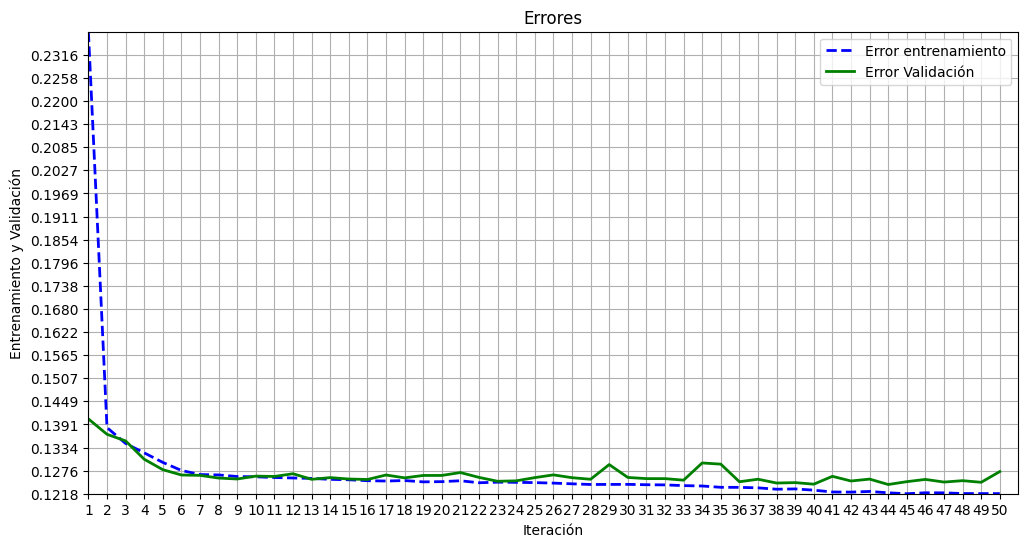

In [29]:
import numpy as np
errores_entrenamiento = history1.history['root_mean_squared_error']
errores_validacion = history1.history['val_root_mean_squared_error']
print(history1.history.keys())
print(errores_entrenamiento)
print(errores_validacion)

min_errores_entrenamiento = np.min(errores_entrenamiento)
min_errores_validacion = np.min(errores_validacion)
min = np.min([min_errores_entrenamiento,min_errores_validacion])

max_errores_entrenamiento = np.max(errores_entrenamiento)
max_errores_validacion = np.max(errores_validacion)
max = np.max([max_errores_entrenamiento,max_errores_validacion])



import matplotlib.pyplot as plt


iteraciones = np.arange(1, n_iter+1, 1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.grid(True)
ax.axis((1, n_iter+1, min, max))
ax.set_xticks(iteraciones)
ax.set_yticks(np.arange(min, max, (max-min)/20))

ax.plot(iteraciones, errores_entrenamiento, "b--", label="Entrenamiento", linewidth=2)
ax.plot(iteraciones, errores_validacion, "g-", label="Validación", linewidth=2)

ax.legend(["Error entrenamiento", "Error Validación"])

plt.title('Errores')
plt.xlabel('Iteración')
plt.ylabel('Entrenamiento y Validación')
plt.show()

## Clasificacion

In [35]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)
y_raw = datos_estudiantes_scaled['mark'] 


le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print("Clases:", list(le.classes_))

#División en train, validación y test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

#Se le da un peso diferente a las clases. Así, si una clase tiene menos ejemplos, se le da más peso para evitar el desbalance. A una clase con más ejemplos, se le da un menor peso.
class_weights_arr = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("class_weights:", class_weights)


Clases: [0.0, 0.25, 0.5, 0.75, 1.0]
class_weights: {0: 0.7401533174729051, 1: 1.1272141706924315, 2: 1.0443864229765014, 3: 0.71483278018892, 4: 2.4669603524229076}


Definimos funciones para compilar el modelo, entrenarlo y evaluarlo, y mostrar el error graficamente

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt

def compila_modelo(modelo, lr=1e-3):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    modelo.compile(
        optimizer=opt,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ]
    )
    return modelo

def entrena_y_evalua(modelo, X_train, y_train, X_val, y_val, X_test, y_test,
                     epochs=80, batch_size=256, class_weights=None, callbacks=None, verbose=0):
    history = modelo.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks or [],
        verbose=verbose
    )

    # Evaluación final en test
    test_loss, test_acc = modelo.evaluate(X_test, y_test, verbose=0)

    # Reporte (macro-F1, precision/recall por clase, etc.)
    probs = modelo.predict(X_test, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    print("\nTest accuracy:", test_acc)
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))
    print("Confusion matrix (test):\n", confusion_matrix(y_test, y_pred))

    return history, test_acc

def plot_history(history, titulo="Entrenamiento"):
    h = history.history
    epochs = np.arange(1, len(h["loss"]) + 1)

    # Loss
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h["loss"], "--", linewidth=2, label="loss train")
    plt.plot(epochs, h["val_loss"], "-", linewidth=2, label="loss val")
    plt.title(titulo + " | Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h["accuracy"], "--", linewidth=2, label="acc train")
    plt.plot(epochs, h["val_accuracy"], "-", linewidth=2, label="acc val")
    plt.title(titulo + " | Accuracy")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Primer modelo: 
- 5 neuronas de salida
- Softmax como función de salida
- Entropía cruzada como función de pérdida
- Métrica accuracy

In [37]:
def build_model_A(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation="relu")(entrada)
    x = tf.keras.layers.Dense(30, activation="relu")(x)
    salida = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)
num_classes = 5
modeloA = build_model_A(X_train.shape[1], num_classes)
modeloA = compila_modelo(modeloA, lr=1e-3)

histA, accA = entrena_y_evalua(
    modeloA, X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=80, batch_size=256, class_weights=None, verbose=1
)
plot_history(histA, "Modelo A (baseline)")


Epoch 1/80
55/55 [==============================] - 1s 5ms/step - loss: 1.5520 - accuracy: 0.3101 - val_loss: 1.5058 - val_accuracy: 0.3940
Epoch 2/80
55/55 [==============================] - 0s 3ms/step - loss: 1.4502 - accuracy: 0.4461 - val_loss: 1.3733 - val_accuracy: 0.4650
Epoch 3/80
55/55 [==============================] - 0s 3ms/step - loss: 1.2783 - accuracy: 0.4895 - val_loss: 1.2083 - val_accuracy: 0.4953
Epoch 4/80
55/55 [==============================] - 0s 3ms/step - loss: 1.1563 - accuracy: 0.5076 - val_loss: 1.1345 - val_accuracy: 0.5037
Epoch 5/80
55/55 [==============================] - 0s 2ms/step - loss: 1.1085 - accuracy: 0.5139 - val_loss: 1.1225 - val_accuracy: 0.4980
Epoch 6/80
55/55 [==============================] - 0s 2ms/step - loss: 1.0872 - accuracy: 0.5213 - val_loss: 1.0858 - val_accuracy: 0.5160
Epoch 7/80
55/55 [==============================] - 0s 2ms/step - loss: 1.0739 - accuracy: 0.5271 - val_loss: 1.0754 - val_accuracy: 0.5240
Epoch 8/80
55/55 [==

TypeError: object of type 'numpy.float64' has no len()

In [30]:
from sklearn.model_selection import train_test_split

X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)
y = datos_estudiantes_scaled['mark']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
import tensorflow as tf


nivel_oculto1 = tf.keras.layers.Dense(30, activation="relu")
nivel_oculto2 = tf.keras.layers.Dense(30, activation="relu")
nivel_union = tf.keras.layers.Concatenate()
nivel_salida = tf.keras.layers.Dense(1)

entrada = tf.keras.layers.Input(shape=X_train.shape[1:])
oculto1 = nivel_oculto1(entrada)
oculto2 = nivel_oculto2(oculto1)
salida = nivel_salida(oculto2)

modelo1 = tf.keras.Model(inputs=[entrada], outputs=[salida])
optimizador = tf.keras.optimizers.Adam(learning_rate=1e-3)  #learning_rate=1e-3
modelo1.compile(optimizer=optimizador, loss="mse", metrics=["RootMeanSquaredError"])
n_iter = 50
history1 = modelo1.fit(X_train, y_train, epochs=n_iter,
                       validation_data=(X_test, y_test))
import numpy as np


errores_entrenamiento = history1.history['RootMeanSquaredError']
errores_validacion = history1.history['val_RootMeanSquaredError']
print(history1.history.keys())
print(errores_entrenamiento)
print(errores_validacion)

min_errores_entrenamiento = np.min(errores_entrenamiento)
min_errores_validacion = np.min(errores_validacion)
min = np.min([min_errores_entrenamiento, min_errores_validacion])

max_errores_entrenamiento = np.max(errores_entrenamiento)
max_errores_validacion = np.max(errores_validacion)
max = np.max([max_errores_entrenamiento, max_errores_validacion])

import matplotlib.pyplot as plt


iteraciones = np.arange(1, n_iter + 1, 1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.grid(True)
ax.axis((1, n_iter + 1, min, max))
ax.set_xticks(iteraciones)
ax.set_yticks(np.arange(min, max, (max - min) / 20))

ax.plot(iteraciones, errores_entrenamiento, "b--", label="Entrenamiento", linewidth=2)
ax.plot(iteraciones, errores_validacion, "g-", label="Validación", linewidth=2)

ax.legend(["Error entrenamiento", "Error Validación"])

plt.title('Errores')
plt.xlabel('Iteración')
plt.ylabel('Entrenamiento y Validación')
plt.show()

Epoch 1/50
500/500 [==============================] - 2s 2ms/step - loss: 0.0626 - root_mean_squared_error: 0.2501 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0415 - root_mean_squared_error: 0.2038 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2002
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0398 - root_mean_squared_error: 0.1996 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1985
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1928
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1928
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.0367 - val_

KeyError: 'RootMeanSquaredError'

ÚLTIMO

In [38]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# X: variables predictoras (escaladas); y: etiqueta (NO escalada)
X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)

# y debe salir de datos_estudiantes (antes del MinMaxScaler), para evitar clases 0.0, 0.25, ...
y_raw = datos_estudiantes['mark'].copy()

# Si mark está en texto, se mapea a 0..4; si ya está en 0..4, se fuerza a int
mapa_mark = {'failed': 0, 'passed': 1, 'good': 2, 'merit': 3, 'excellent': 4, 'Excellent': 4}
if y_raw.dtype == object:
    y = y_raw.map(mapa_mark).astype(int).to_numpy()
else:
    y = y_raw.astype(int).to_numpy()

class_names = ['failed', 'passed', 'good', 'merit', 'excellent']
num_classes = 5

# Split estratificado: train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Pesos por clase (recomendable si hay desbalance)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

print('Distribución train:', dict(zip(*np.unique(y_train, return_counts=True))))
print('class_weights:', class_weights)


Distribución train: {0: 3783, 1: 2484, 2: 2681, 3: 3917, 4: 1135}
class_weights: {0: 0.7401533174729051, 1: 1.1272141706924315, 2: 1.0443864229765014, 3: 0.71483278018892, 4: 2.4669603524229076}


In [39]:
import matplotlib.pyplot as plt

def plot_history(history, titulo):
    h = history.history
    epochs = np.arange(1, len(h['loss']) + 1)

    # Loss
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['loss'], '--', linewidth=2, label='loss train')
    plt.plot(epochs, h['val_loss'], '-', linewidth=2, label='loss val')
    plt.title(titulo + ' | Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['accuracy'], '--', linewidth=2, label='acc train')
    plt.plot(epochs, h['val_accuracy'], '-', linewidth=2, label='acc val')
    plt.title(titulo + ' | Accuracy')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evalua_clasificacion(modelo, X_test, y_test):
    probs = modelo.predict(X_test, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    print('Confusion matrix (test):')
    print(confusion_matrix(y_test, y_pred))

    print('\nClassification report (test):')
    # target_names tiene que ser lista de strings
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


In [40]:
# Callbacks para ir mejorando el entrenamiento sin cambios bruscos
cb_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

cb_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)


Epoch 1/100
55/55 [==============================] - 1s 6ms/step - loss: 1.5639 - accuracy: 0.2887 - val_loss: 1.4912 - val_accuracy: 0.4233
Epoch 2/100
55/55 [==============================] - 0s 3ms/step - loss: 1.4244 - accuracy: 0.4590 - val_loss: 1.3556 - val_accuracy: 0.4740
Epoch 3/100
55/55 [==============================] - 0s 3ms/step - loss: 1.2734 - accuracy: 0.4908 - val_loss: 1.2137 - val_accuracy: 0.4990
Epoch 4/100
55/55 [==============================] - 0s 2ms/step - loss: 1.1636 - accuracy: 0.5072 - val_loss: 1.1402 - val_accuracy: 0.5060
Epoch 5/100
55/55 [==============================] - 0s 2ms/step - loss: 1.1111 - accuracy: 0.5174 - val_loss: 1.1070 - val_accuracy: 0.5097
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 1.0833 - accuracy: 0.5202 - val_loss: 1.0849 - val_accuracy: 0.5140
Epoch 7/100
55/55 [==============================] - 0s 2ms/step - loss: 1.0651 - accuracy: 0.5250 - val_loss: 1.0696 - val_accuracy: 0.5327
Epoch 8/100
5

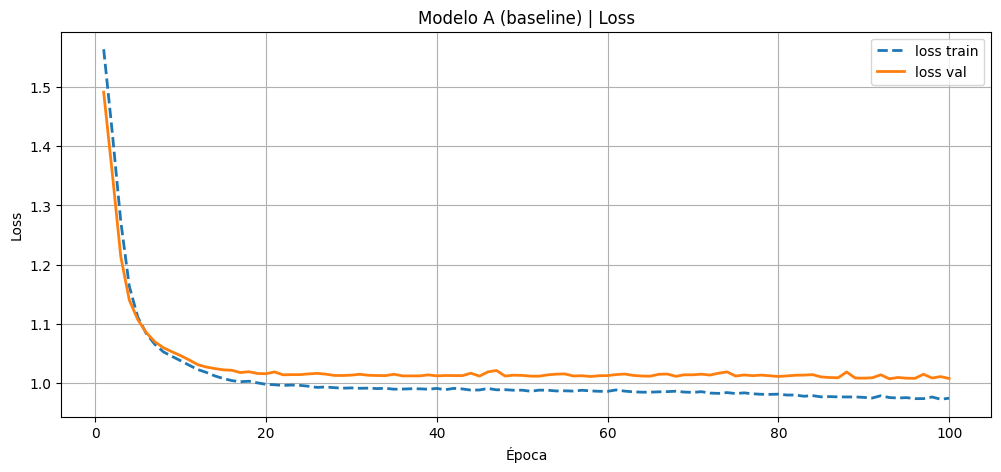

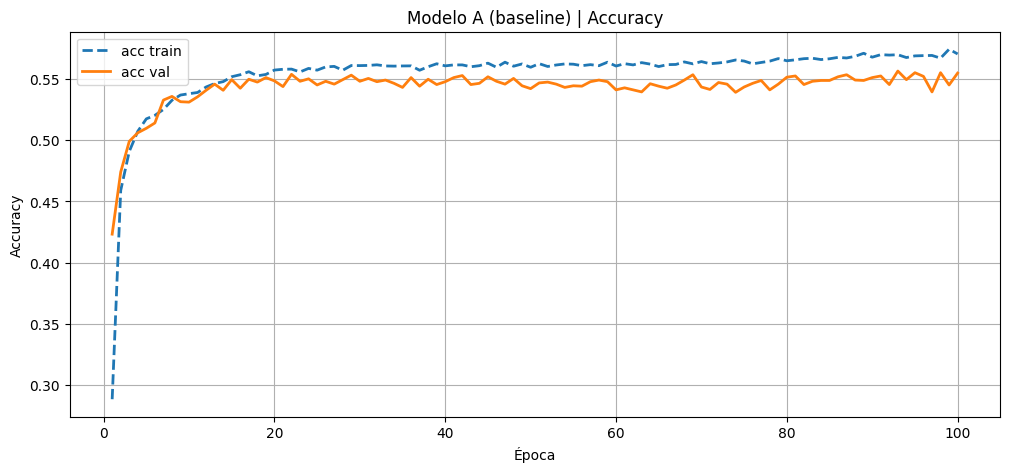

Confusion matrix (test):
[[647 114  34  16   0]
 [221 143  90  78   0]
 [ 67 114 131 260   3]
 [ 16  46  89 636  52]
 [  0   0   4 147  92]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.6803    0.7978    0.7344       811
      passed     0.3429    0.2688    0.3014       532
        good     0.3764    0.2278    0.2839       575
       merit     0.5594    0.7580    0.6437       839
   excellent     0.6259    0.3786    0.4718       243

    accuracy                         0.5497      3000
   macro avg     0.5170    0.4862    0.4870      3000
weighted avg     0.5240    0.5497    0.5246      3000



In [41]:
def build_model_A(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation='relu')(entrada)
    x = tf.keras.layers.Dense(30, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloA = build_model_A(X_train.shape[1], num_classes)
modeloA.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyA = modeloA.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    verbose=1
)

plot_history(historyA, 'Modelo A (baseline)')
evalua_clasificacion(modeloA, X_test, y_test)


Epoch 1/300
55/55 [==============================] - 1s 6ms/step - loss: 1.5615 - accuracy: 0.2913 - val_loss: 1.5062 - val_accuracy: 0.3763
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 1.4416 - accuracy: 0.4434 - val_loss: 1.3696 - val_accuracy: 0.4760
Epoch 3/300
55/55 [==============================] - 0s 3ms/step - loss: 1.2760 - accuracy: 0.4922 - val_loss: 1.2113 - val_accuracy: 0.4913
Epoch 4/300
55/55 [==============================] - 0s 3ms/step - loss: 1.1596 - accuracy: 0.5050 - val_loss: 1.1395 - val_accuracy: 0.4997
Epoch 5/300
55/55 [==============================] - 0s 5ms/step - loss: 1.1133 - accuracy: 0.5147 - val_loss: 1.1121 - val_accuracy: 0.5083
Epoch 6/300
55/55 [==============================] - 0s 3ms/step - loss: 1.0916 - accuracy: 0.5183 - val_loss: 1.0946 - val_accuracy: 0.5127
Epoch 7/300
55/55 [==============================] - 0s 3ms/step - loss: 1.0785 - accuracy: 0.5242 - val_loss: 1.0861 - val_accuracy: 0.5073
Epoch 8/300
5

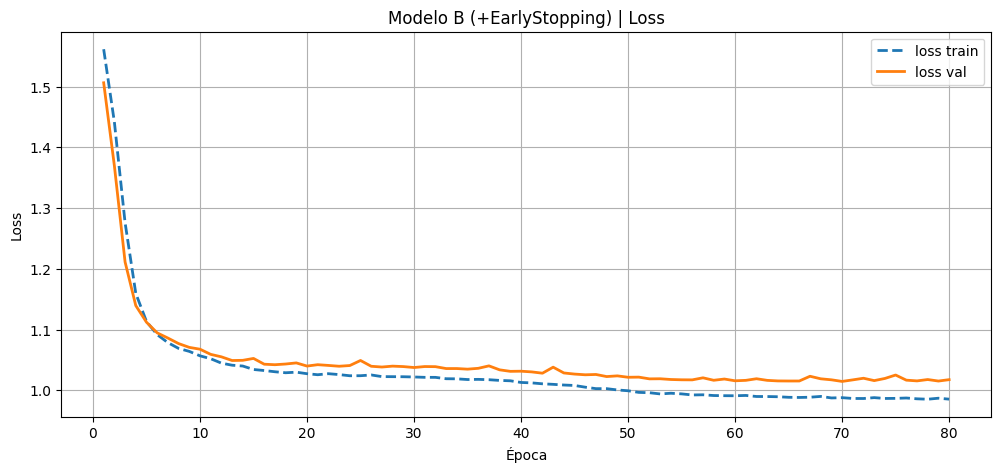

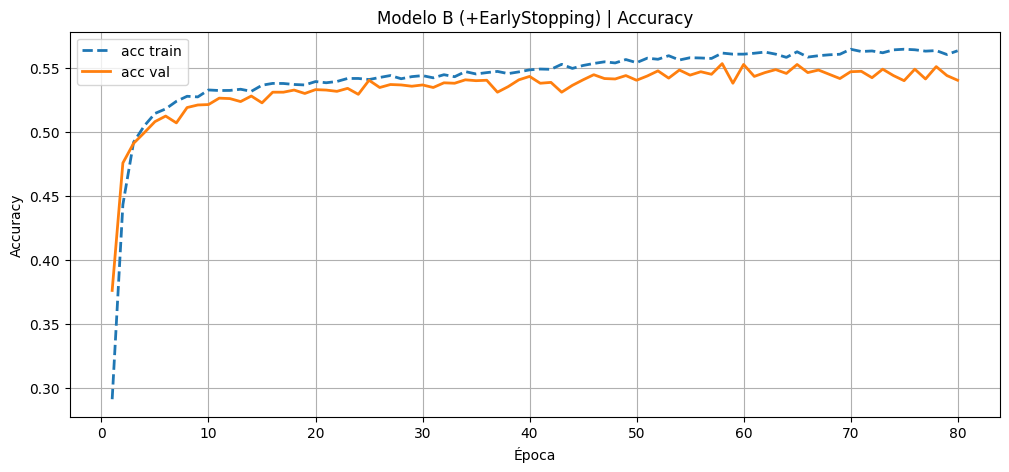

Confusion matrix (test):
[[638 110  50  13   0]
 [212 134 110  76   0]
 [ 70  96 154 251   4]
 [ 19  36 116 614  54]
 [  0   0   5 147  91]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.6794    0.7867    0.7291       811
      passed     0.3564    0.2519    0.2952       532
        good     0.3540    0.2678    0.3050       575
       merit     0.5577    0.7318    0.6330       839
   excellent     0.6107    0.3745    0.4643       243

    accuracy                         0.5437      3000
   macro avg     0.5117    0.4825    0.4853      3000
weighted avg     0.5202    0.5437    0.5225      3000



In [42]:
modeloB = build_model_A(X_train.shape[1], num_classes)
modeloB.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyB = modeloB.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=256,
    callbacks=[cb_early],
    verbose=1
)

plot_history(historyB, 'Modelo B (+EarlyStopping)')
evalua_clasificacion(modeloB, X_test, y_test)


Epoch 1/300
55/55 [==============================] - 1s 7ms/step - loss: 1.5156 - accuracy: 0.3496 - val_loss: 1.3950 - val_accuracy: 0.4720
Epoch 2/300
55/55 [==============================] - 0s 4ms/step - loss: 1.3371 - accuracy: 0.4529 - val_loss: 1.2104 - val_accuracy: 0.4863
Epoch 3/300
55/55 [==============================] - 0s 4ms/step - loss: 1.2159 - accuracy: 0.4787 - val_loss: 1.1371 - val_accuracy: 0.5147
Epoch 4/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1710 - accuracy: 0.4941 - val_loss: 1.1109 - val_accuracy: 0.5080
Epoch 5/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1458 - accuracy: 0.4991 - val_loss: 1.0940 - val_accuracy: 0.5123
Epoch 6/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1202 - accuracy: 0.5096 - val_loss: 1.0794 - val_accuracy: 0.5163
Epoch 7/300
55/55 [==============================] - 0s 4ms/step - loss: 1.1159 - accuracy: 0.5123 - val_loss: 1.0692 - val_accuracy: 0.5210
Epoch 8/300
5

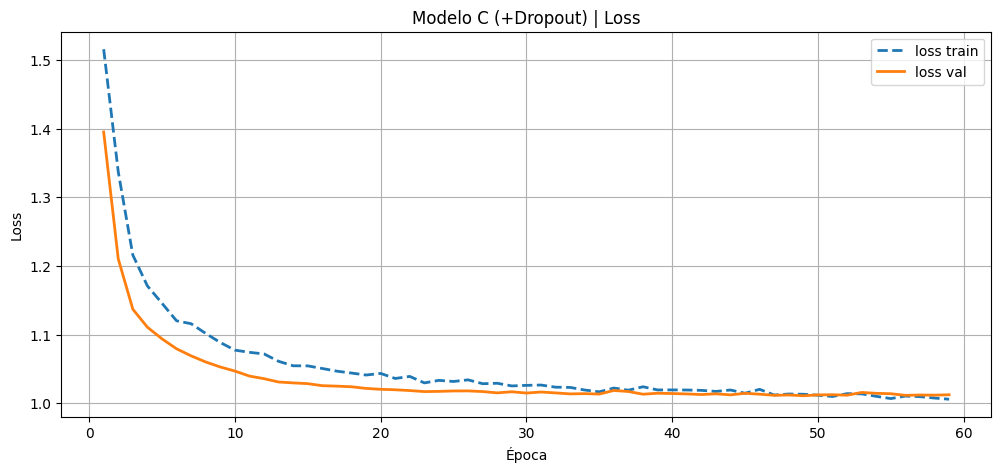

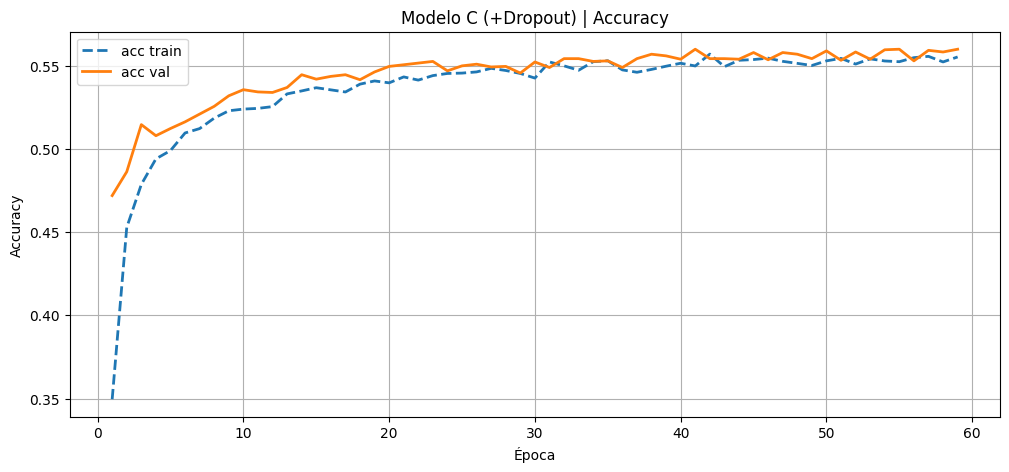

Confusion matrix (test):
[[653 106  36  16   0]
 [223 145  69  95   0]
 [ 65 121 115 270   4]
 [ 18  41  88 641  51]
 [  0   0   5 145  93]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.6809    0.8052    0.7379       811
      passed     0.3511    0.2726    0.3069       532
        good     0.3674    0.2000    0.2590       575
       merit     0.5493    0.7640    0.6391       839
   excellent     0.6284    0.3827    0.4757       243

    accuracy                         0.5490      3000
   macro avg     0.5154    0.4849    0.4837      3000
weighted avg     0.5213    0.5490    0.5208      3000



In [43]:
def build_model_C(input_dim, num_classes, dropout=0.25):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(entrada)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloC = build_model_C(X_train.shape[1], num_classes, dropout=0.25)
modeloC.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyC = modeloC.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=256,
    callbacks=[cb_early],
    verbose=1
)

plot_history(historyC, 'Modelo C (+Dropout)')
evalua_clasificacion(modeloC, X_test, y_test)


Epoch 1/400
55/55 [==============================] - 2s 12ms/step - loss: 1.5400 - accuracy: 0.3364 - val_loss: 1.5569 - val_accuracy: 0.2813 - lr: 8.0000e-04
Epoch 2/400
55/55 [==============================] - 0s 7ms/step - loss: 1.2870 - accuracy: 0.4099 - val_loss: 1.4791 - val_accuracy: 0.3220 - lr: 8.0000e-04
Epoch 3/400
55/55 [==============================] - 0s 6ms/step - loss: 1.2074 - accuracy: 0.4371 - val_loss: 1.3975 - val_accuracy: 0.3637 - lr: 8.0000e-04
Epoch 4/400
55/55 [==============================] - 0s 5ms/step - loss: 1.1672 - accuracy: 0.4531 - val_loss: 1.3240 - val_accuracy: 0.3953 - lr: 8.0000e-04
Epoch 5/400
55/55 [==============================] - 0s 5ms/step - loss: 1.1514 - accuracy: 0.4586 - val_loss: 1.2545 - val_accuracy: 0.4200 - lr: 8.0000e-04
Epoch 6/400
55/55 [==============================] - 0s 5ms/step - loss: 1.1291 - accuracy: 0.4761 - val_loss: 1.2015 - val_accuracy: 0.4517 - lr: 8.0000e-04
Epoch 7/400
55/55 [==============================] 

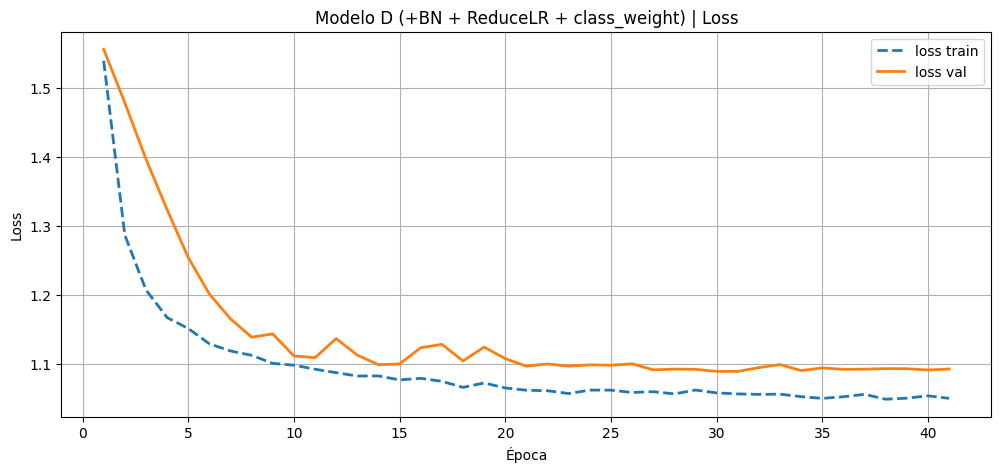

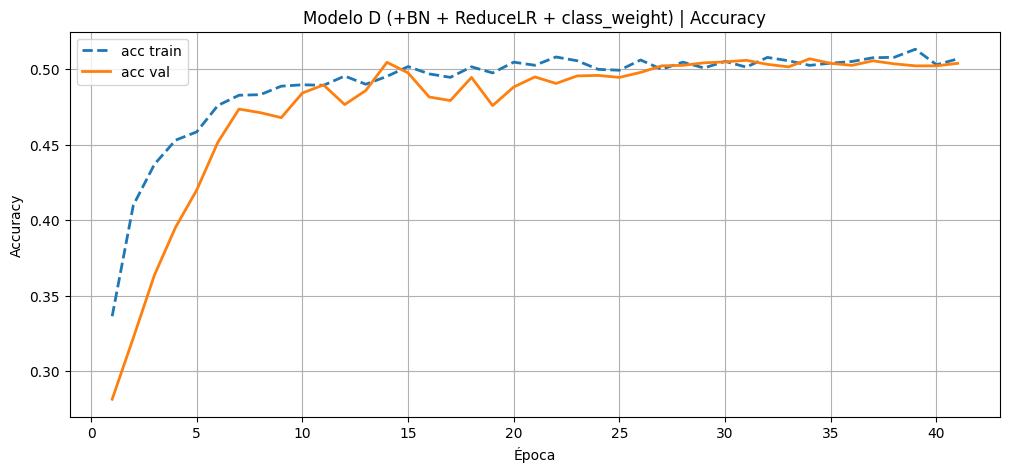

Confusion matrix (test):
[[565 197  43   6   0]
 [150 218 131  29   4]
 [ 43 147 214 138  33]
 [ 11  52 205 309 262]
 [  0   0   8  48 187]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.7347    0.6967    0.7152       811
      passed     0.3550    0.4098    0.3805       532
        good     0.3561    0.3722    0.3639       575
       merit     0.5830    0.3683    0.4514       839
   excellent     0.3848    0.7695    0.5130       243

    accuracy                         0.4977      3000
   macro avg     0.4827    0.5233    0.4848      3000
weighted avg     0.5240    0.4977    0.4984      3000



In [44]:
from tensorflow.keras import regularizers

def build_model_D(input_dim, num_classes, dropout=0.25, l2=1e-4):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    x = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(l2))(entrada)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloD = build_model_D(X_train.shape[1], num_classes, dropout=0.30, l2=1e-4)
modeloD.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyD = modeloD.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)

plot_history(historyD, 'Modelo D (+BN + ReduceLR + class_weight)')
evalua_clasificacion(modeloD, X_test, y_test)
